# Model Development

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline



from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from keras.optimizers import Adam

from src.data import get_data
from src.util import common

from src.features.build_features import series_to_supervised

import pickle

Using TensorFlow backend.
/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)


In [2]:
df = pd.read_csv(common.get_project_path() + '/data/raw/data.csv', index_col=0)
df.timestamp = pd.to_datetime(df.timestamp)
df.drop('time', axis=1, inplace=True)
df.head()

,volumeto,volumefrom,open,high,close,low,timestamp
0,143.50,1.00,114.51,143.50,143.50,114.51,2013-06-27 13:00:00
1,0.00,0.00,143.50,143.50,143.50,143.50,2013-06-27 14:00:00
2,239.99,1.99,104.65,120.59,120.59,104.65,2013-06-27 15:00:00
3,1341.82,11.63,115.05,120.57,114.08,114.08,2013-06-27 16:00:00
4,347.96,3.04,116.62,143.97,108.65,108.65,2013-06-27 17:00:00


In [3]:
MAS = [6, 12,24,48]
for MA in MAS:
    df['vt_ma' + str(MA)] = df.volumeto.rolling(MA).mean()
    df['vf_ma' + str(MA)] = df.volumefrom.rolling(MA).mean()
#     df['close_ma' + str(MA)] = df.volumeto.rolling(MA).mean()

In [4]:
# df['hour'] = df.timestamp.dt.hour
# df['dom'] = df.timestamp.dt.day
# df['dow'] = df.timestamp.dt.dayofweek
df.drop('timestamp', axis=1, inplace=True)
df.drop(['volumefrom', 'volumeto'], axis=1, inplace=True)

In [5]:
df.head(10)

,open,high,close,low,vt_ma6,vf_ma6,vt_ma12,vf_ma12,vt_ma24,vf_ma24,vt_ma48,vf_ma48
0,114.51,143.50,143.50,114.51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,143.50,143.50,143.50,143.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,104.65,120.59,120.59,104.65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,115.05,120.57,114.08,114.08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,116.62,143.97,108.65,108.65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,115.15,121.08,121.08,113.97,494.791667,4.225000,NaN,NaN,NaN,NaN,NaN,NaN
6,120.73,120.73,107.18,104.53,854.765000,7.585000,NaN,NaN,NaN,NaN,NaN,NaN
7,108.77,132.55,106.90,103.89,1111.486667,9.898333,NaN,NaN,NaN,NaN,NaN,NaN
8,106.90,114.59,109.06,106.90,1109.731667,9.916667,NaN,NaN,NaN,NaN,NaN,NaN
9,143.50,143.50,100.58,100.58,1479.538333,13.578333,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
START_INDEX = 36000
N_FEATURES = len(df.columns)

Tx = 96
Ty = 6

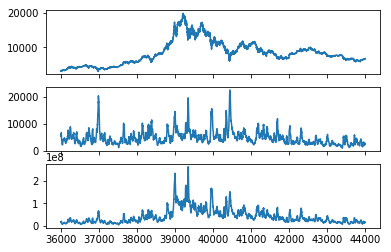

In [18]:
"""
Cut off first ### hours from data set. The OHCLV data is much different in Bitcoin's earlier days. 
Getting rid of this data will hopefully improve the model.
"""
sample = df.iloc[START_INDEX:,:]
sample.shape
fig, ax = plt.subplots(3, sharex=True)
ax[0].plot(sample.close)
ax[1].plot(sample.vf_ma24)
ax[2].plot(sample.vt_ma24)

In [19]:
X = series_to_supervised(data=sample, n_in=Tx, n_out=Ty)
X.head()

,var1(t-96),var2(t-96),var3(t-96),var4(t-96),var5(t-96),var6(t-96),var7(t-96),var8(t-96),var9(t-96),var10(t-96),...,var3(t+5),var4(t+5),var5(t+5),var6(t+5),var7(t+5),var8(t+5),var9(t+5),var10(t+5),var11(t+5),var12(t+5)
36096,3191.55,3192.94,3145.95,3142.31,1.817895e+07,5732.011667,2.459202e+07,7927.283333,1.650966e+07,5434.913333,...,3315.68,3286.05,1.608918e+07,4884.011667,1.563200e+07,4710.610000,1.503810e+07,4471.563750,1.487727e+07,4395.017292
36097,3145.95,3170.07,3159.68,3142.10,1.685689e+07,5308.758333,2.475590e+07,7961.445000,1.649175e+07,5416.469167,...,3335.55,3312.50,1.422703e+07,4317.170000,1.572332e+07,4742.320833,1.494187e+07,4446.025833,1.470766e+07,4345.455625
36098,3159.68,3185.48,3182.72,3158.01,1.606055e+07,5047.965000,2.505795e+07,8039.363333,1.660446e+07,5441.731667,...,3324.34,3322.66,1.224565e+07,3720.196667,1.529677e+07,4617.509167,1.444222e+07,4298.693750,1.445475e+07,4269.939792
36099,3182.72,3229.12,3228.81,3171.01,1.559975e+07,4892.261667,2.426865e+07,7723.345833,1.707200e+07,5575.338333,...,3340.10,3321.43,1.229441e+07,3730.353333,1.533762e+07,4633.690833,1.369385e+07,4083.521250,1.436740e+07,4244.157500
36100,3228.81,3229.72,3200.87,3184.85,1.387765e+07,4357.090000,1.914275e+07,6045.358333,1.731189e+07,5634.531667,...,3366.74,3338.95,1.150829e+07,3462.475000,1.621810e+07,4898.077500,1.377714e+07,4113.583750,1.440097e+07,4254.220000


In [20]:
Y = series_to_supervised(data=list(sample['close']), n_in=Tx, n_out=Ty)
Y.head()

,var1(t-96),var1(t-95),var1(t-94),var1(t-93),var1(t-92),var1(t-91),var1(t-90),var1(t-89),var1(t-88),var1(t-87),...,var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t),var1(t+1),var1(t+2),var1(t+3),var1(t+4),var1(t+5)
96,3145.95,3159.68,3182.72,3228.81,3200.87,3297.57,3313.11,3296.30,3270.81,3254.66,...,3413.52,3392.63,3370.04,3304.35,3321.46,3326.16,3300.85,3254.24,3300.13,3315.68
97,3159.68,3182.72,3228.81,3200.87,3297.57,3313.11,3296.30,3270.81,3254.66,3237.78,...,3392.63,3370.04,3304.35,3321.46,3326.16,3300.85,3254.24,3300.13,3315.68,3335.55
98,3182.72,3228.81,3200.87,3297.57,3313.11,3296.30,3270.81,3254.66,3237.78,3235.26,...,3370.04,3304.35,3321.46,3326.16,3300.85,3254.24,3300.13,3315.68,3335.55,3324.34
99,3228.81,3200.87,3297.57,3313.11,3296.30,3270.81,3254.66,3237.78,3235.26,3262.80,...,3304.35,3321.46,3326.16,3300.85,3254.24,3300.13,3315.68,3335.55,3324.34,3340.10
100,3200.87,3297.57,3313.11,3296.30,3270.81,3254.66,3237.78,3235.26,3262.80,3271.93,...,3321.46,3326.16,3300.85,3254.24,3300.13,3315.68,3335.55,3324.34,3340.10,3366.74


# train dev split

In [21]:
"""
Train dev split. (80/20) rule is kind of over. Taking the dev set from the end of the data set because 
that data is closest in distribution to our current testing scenario (getting real time predictions). Note: I call
the dev set the 'test' set in the variable names, but it's really a dev set.
"""
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.05, shuffle=False)
"""
Now trim the feature values from the outcome matrix and the outcome values from the feature matrix
"""
Y_test_cache = Y_test
Y_train = Y_train.iloc[:,-Ty:]
Y_test = Y_test.iloc[:,-Ty:]
X_train = X_train.iloc[:,:-(Ty*N_FEATURES)]
X_test = X_test.iloc[:,:-(Ty*N_FEATURES)]


# Let's try a simple linear regression model

In [22]:
from sklearn.linear_model import LinearRegression


lr_model = LinearRegression()
lr_model = lr_model.fit(X_train, Y_train)

lr_model.score(X_test, Y_test)

0.8525677596275509

In [23]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
lr_predict = lr_model.predict(X_test)
mean_absolute_error(lr_predict, Y_test), mean_squared_error(lr_predict, Y_test)

(67.56365703460845, 10547.927018327455)

In [24]:
# Save model
with open(project_path + '/models/linear_model_btc.pkl', 'wb') as output_file:
    s = pickle.dump(lr_model, output_file)


NameError: name 'project_path' is not defined

## Much better! Makes a lot more sense.

# Other Linear Regression

## Lasso

In [25]:
from sklearn.linear_model import Lasso, MultiTaskLassoCV
lasso_params = {
    'alpha': [0.01]
}
lasso_model = Lasso(alpha=0.01, max_iter=10000)
lasso_model = lasso_model.fit(X=X_train, y=Y_train)
lasso_model.score(X=X_test, y=Y_test)

/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.879598667670454

In [26]:

lasso_predict = lasso_model.predict(X_test)
mean_absolute_error(lasso_predict, Y_test), mean_squared_error(lasso_predict, Y_test)


(58.1987294375528, 8614.021350507572)

## Ridge


In [27]:
from sklearn.linear_model import Ridge, RidgeCV

ridge_model = Ridge(alpha=0.01)
ridge_model = ridge_model.fit(X=X_train, y=Y_train)
ridge_model.score(X=X_test, y=Y_test)

0.8690065491065722

In [28]:
ridge_predict = ridge_model.predict(X_test)
mean_absolute_error(ridge_predict, Y_test)

61.902134043458666

## Elastic Net

In [30]:
from sklearn.linear_model import MultiTaskElasticNet, MultiTaskElasticNetCV, ElasticNet, ElasticNetCV
enet_params = {
    'alpha': [0.0000001]
}
enet_model = MultiTaskElasticNetCV(alphas=enet_params['alpha'])
enet_model = enet_model.fit(X=X_train, y=Y_train)
enet_model.score(X=X_train, y=Y_train)
enet_model.alpha_

/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:1778: ConvergenceWarning: Objective did not converge, you might want to increase the number of iterations
  ConvergenceWarning)


1e-07

In [31]:
enet_predict = enet_model.predict(X_test)
mean_absolute_error(enet_predict, Y_test), mean_squared_error(enet_predict, Y_test)

(58.0005253929336, 8349.440064576107)

In [176]:
from sklearn.linear_model import SGDRegressor

sgd_model = SGDRegressor(alpha=0.01, max_iter=10000)
sgd_model.fit(X=X_train, y=Y_train)
sgd_model.score(X=X_test, y=Y_test)

/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


-3.3435487358198715e+45

In [177]:
sgd_predict = sgd_model.predict(X=X_test)
mean_absolute_error(sgd_predict, Y_test)

1.3102657134657168e+25

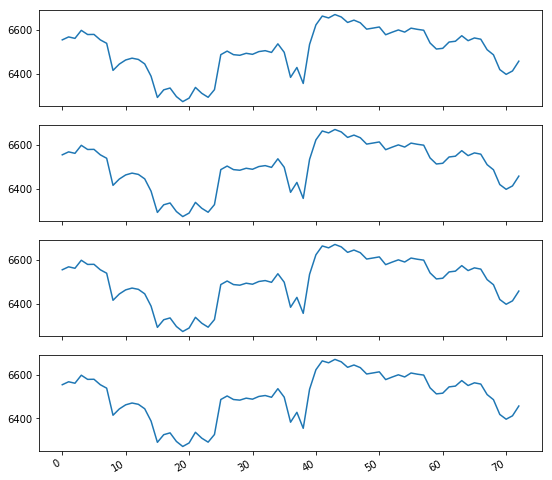

In [186]:
num_predict = 4
predictions = pd.DataFrame({
    'linear': lr_predict.ravel(),
    'lasso': lasso_predict,
    'ridge': ridge_predict.ravel(),
    'enet': enet_predict,
#     'sgd': sgd_predict
})
# predictions['time'] = 73
predictions
fig, ax = plt.subplots(num_predict, sharey=True)
fig.set_size_inches(9,9)
for ii, ix in enumerate(np.random.randint(0,Y_test_cache.shape[0],num_predict)):
    axis = ax[ii]  
    axis.plot(actual)
#     axis.plot(predictions.iloc[[ii]])
fig.autofmt_xdate()

In [127]:
np.ones(predictions.shape[1])

array([1., 1.])

In [130]:
np.ones(5)*(Tx+Ty)

array([73., 73., 73., 73., 73.])